In [1]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, welch
from scipy.stats import entropy


In [2]:
# CONFIG
input_pattern = "/rds/general/user/nk2622/projects/ppmi_verily/live/STUDYWATCH/NiharikaPPMI/*/accelerometer/csv/*_activity_3_17_trimmed.csv"
output_csv = "/rds/general/user/nk2622/home/tremor_features_per_participant.csv"

fs = 25  # Sampling frequency
tremor_band = (4, 7)  # Hz


In [3]:
def bandpass_filter(data, fs=25, lowcut=3, highcut=7, order=4):
    from scipy.signal import butter, filtfilt
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, data)

def compute_bandpower(data, fs, band):
    f, Pxx = welch(data, fs=fs, nperseg=min(len(data), fs*2))
    idx = np.logical_and(f >= band[0], f <= band[1])
    return np.trapz(Pxx[idx], f[idx])

def compute_entropy(data, fs):
    f, Pxx = welch(data, fs=fs, nperseg=min(len(data), fs*2))
    Pxx_norm = Pxx / np.sum(Pxx)
    return entropy(Pxx_norm)

def zero_crossing_rate(sig):
    centered = sig - np.mean(sig)
    return ((centered[:-1] * centered[1:]) < 0).sum() / len(sig)


In [4]:
import numpy as np
import pandas as pd
import glob, os
from scipy.signal import butter, filtfilt, welch
from scipy.stats import entropy

# === Parameters ===
fs = 25
tremor_band = (3, 7)

#  Use the correct folder with trimmed CSVs
input_pattern = "/rds/general/user/nk2622/projects/ppmi_verily/live/STUDYWATCH/NiharikaPPMI/*/accelerometer/csv/*_activity_3_17_trimmed.csv"

def bandpass_filter(signal, fs=25, lowcut=3, highcut=7, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)

def compute_bandpower(signal, fs=25, band=(3, 7)):
    f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 512), window='hanning')
    band_idx = (f >= band[0]) & (f <= band[1])
    return np.trapz(Pxx[band_idx], f[band_idx]) if band_idx.any() else np.nan

def compute_entropy(signal, fs=25):
    f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 512), window='hanning')
    Pxx_norm = Pxx / np.sum(Pxx) if np.sum(Pxx) > 0 else np.ones_like(Pxx)
    return entropy(Pxx_norm)

def zero_crossing_rate(signal):
    return np.sum(np.diff(np.sign(signal)) != 0) / len(signal)

features = []
files = glob.glob(input_pattern)
print(f"📂 Found {len(files)} files")

for file in files:
    pid = os.path.basename(file).split('_')[0]
    try:
        df = pd.read_csv(file)
        if len(df) < 512:
            print(f" Skipping {pid}: too few rows ({len(df)})")
            continue

        if not {'x', 'y', 'z'}.issubset(df.columns):
            print(f" Skipping {pid} (missing axes): {df.columns.tolist()}")
            continue

        x, y, z = df['x'], df['y'], df['z']
        mag = np.sqrt(x**2 + y**2 + z**2)

        amp = np.mean([
            np.std(bandpass_filter(x, fs, *tremor_band)),
            np.std(bandpass_filter(y, fs, *tremor_band)),
            np.std(bandpass_filter(z, fs, *tremor_band))
        ])

        bp = compute_bandpower(mag, fs, tremor_band)
        ent = np.mean([compute_entropy(axis, fs) for axis in [x, y, z]])
        sma = (np.sum(np.abs(x)) + np.sum(np.abs(y)) + np.sum(np.abs(z))) / len(x)

        c_xy = np.corrcoef(x, y)[0, 1]
        c_xz = np.corrcoef(x, z)[0, 1]
        c_yz = np.corrcoef(y, z)[0, 1]

        zcr_x = zero_crossing_rate(x)
        zcr_y = zero_crossing_rate(y)
        zcr_z = zero_crossing_rate(z)

        features.append({
            'participant_id': pid,
            'tremor_amp': amp,
            'tremor_bandpower': bp,
            'entropy': ent,
            'sma': sma,
            'corr_xy': c_xy,
            'corr_xz': c_xz,
            'corr_yz': c_yz,
            'zcr_x': zcr_x,
            'zcr_y': zcr_y,
            'zcr_z': zcr_z
        })
        print(f" Extracted: {pid}")

    except Exception as e:
        print(f" Error for {pid}: {e}")

# Save
features_df = pd.DataFrame(features)
features_df.to_csv("/rds/general/user/nk2622/home/tremor_features_per_participant.csv", index=False)
print(f" Saved {len(features_df)} rows to tremor_features_per_participant.csv")


📂 Found 63 files
 Extracted: 55251
 Extracted: 74977
 Extracted: 4055
 Extracted: 75441
 Extracted: 58721
 Extracted: 3207
 Extracted: 3068
 Extracted: 70810
 Extracted: 3055
 Extracted: 3002
 Extracted: 60171
 Extracted: 59178
 Extracted: 75484
 Extracted: 70519
 Extracted: 4074
 Extracted: 52982
 Extracted: 4108
 Extracted: 12593
 Extracted: 14281
 Extracted: 3021
 Extracted: 13039
 Extracted: 3062
 Extracted: 4072
 Extracted: 60013
 Extracted: 3023
 Extracted: 18567
 Extracted: 55842
 Extracted: 3466
 Extracted: 42888
 Extracted: 56779
 Extracted: 51867
 Extracted: 4056
 Extracted: 70378
 Extracted: 3227
 Extracted: 70652
 Extracted: 3220
 Extracted: 57887
 Extracted: 18491
 Extracted: 3020
 Extracted: 91097
 Extracted: 3415
 Extracted: 3003
 Extracted: 3223
 Extracted: 55151
 Extracted: 72651
 Extracted: 3004
 Extracted: 3464
 Extracted: 3424
 Extracted: 75512
 Extracted: 74067
 Extracted: 55094
 Extracted: 71093
 Extracted: 3570
 Extracted: 52888
 Extracted: 74497
 Extracted: 4054

In [5]:
features_df = pd.DataFrame(features)
features_df.to_csv(output_csv, index=False)
print(f" Saved tremor features to: {output_csv}")


 Saved tremor features to: /rds/general/user/nk2622/home/tremor_features_per_participant.csv


In [6]:
import pandas as pd

# === Load feature, metadata, and summary files ===
features_df = pd.read_csv("/rds/general/user/nk2622/home/tremor_features_per_participant.csv")
meta_df = pd.read_csv("/rds/general/user/nk2622/home/final_metadata_PD_HC_trimmed_ON_OFF.csv")
summary_df = pd.read_csv("/rds/general/user/nk2622/home/participant_activity3_17_summary.csv")

# === Step 1: Filter valid participants based on summary file ===
valid_ids = summary_df['Participant_ID'].astype(str).unique()
features_df = features_df[features_df['participant_id'].astype(str).isin(valid_ids)]
meta_df = meta_df[meta_df['participant_id'].astype(str).isin(valid_ids)]

# === Step 2: Merge on participant ID ===
merged_df = features_df.merge(
    meta_df[['participant_id', 'cohort_group', 'updrs3_score', 'NHY', 'ledd']],
    on='participant_id',
    how='inner'
)

# === Step 3: Rename for consistency ===
merged_df.rename(columns={'cohort_group': 'group'}, inplace=True)

# === Step 4: Save merged version ===
output_path = "/rds/general/user/nk2622/home/tremor_features_activity317_filtered.csv"
merged_df.to_csv(output_path, index=False)

print(f" Final merged file saved: {output_path}")
print(f" Unique participants: {merged_df['participant_id'].nunique()}")


 Final merged file saved: /rds/general/user/nk2622/home/tremor_features_activity317_filtered.csv
 Unique participants: 33


In [7]:
print("Shape:", merged_df.shape)
print("Unique participants:", merged_df['participant_id'].nunique())
print("Cohort distribution:\n", merged_df['group'].value_counts())
print("Columns:\n", merged_df.columns.tolist())


Shape: (4002, 15)
Unique participants: 33
Cohort distribution:
 PD    3495
HC     507
Name: group, dtype: int64
Columns:
 ['participant_id', 'tremor_amp', 'tremor_bandpower', 'entropy', 'sma', 'corr_xy', 'corr_xz', 'corr_yz', 'zcr_x', 'zcr_y', 'zcr_z', 'group', 'updrs3_score', 'NHY', 'ledd']


In [8]:
import pandas as pd

# Load trimmed summary
summary_df = pd.read_csv("/rds/general/user/nk2622/home/activity3_17_summary.csv")
trimmed_ids = summary_df['Participant_ID'].astype(str).unique().tolist()
print(f" Found {len(trimmed_ids)} unique trimmed participants")


 Found 66 unique trimmed participants


In [9]:
# Load tremor features and metadata
features = pd.read_csv("/rds/general/user/nk2622/home/tremor_features_per_participant.csv")
metadata = pd.read_csv("/rds/general/user/nk2622/projects/ppmi_verily/live/STUDYWATCH/NiharikaPPMI/final_metadata_PD_HC_trimmed_ON_OFF.csv")

# Filter to only trimmed participants
features['participant_id'] = features['participant_id'].astype(str)
metadata['participant_id'] = metadata['participant_id'].astype(str)
features = features[features['participant_id'].isin(trimmed_ids)]

# Merge with metadata
merged_df = features.merge(metadata[['participant_id', 'cohort_group']], on='participant_id', how='left')
merged_df = merged_df.dropna(subset=['cohort_group'])

print(" Shape:", merged_df.shape)
print(" Unique participants:", merged_df['participant_id'].nunique())
print(" Cohort distribution:\n", merged_df['cohort_group'].value_counts())


 Shape: (4002, 12)
 Unique participants: 33
 Cohort distribution:
 PD    3495
HC     507
Name: cohort_group, dtype: int64


In [10]:
import pandas as pd

features = pd.read_csv("/rds/general/user/nk2622/home/tremor_features_per_participant.csv")
metadata = pd.read_csv("/rds/general/user/nk2622/projects/ppmi_verily/live/STUDYWATCH/NiharikaPPMI/final_metadata_PD_HC_trimmed_ON_OFF.csv")

# Match participant IDs
features['participant_id'] = features['participant_id'].astype(str)
metadata['participant_id'] = metadata['participant_id'].astype(str)

# Merge and filter to valid cohort groups
merged = features.merge(metadata[['participant_id', 'cohort_group', 'updrs3_score', 'NHY', 'ledd']], on='participant_id', how='left')
merged = merged.dropna(subset=['cohort_group'])  # Remove unmatched

print(" Final dataset shape:", merged.shape)


 Final dataset shape: (4002, 15)


In [11]:
print(merged.columns.tolist())


['participant_id', 'tremor_amp', 'tremor_bandpower', 'entropy', 'sma', 'corr_xy', 'corr_xz', 'corr_yz', 'zcr_x', 'zcr_y', 'zcr_z', 'cohort_group', 'updrs3_score', 'NHY', 'ledd']


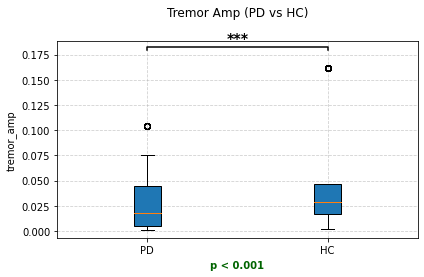

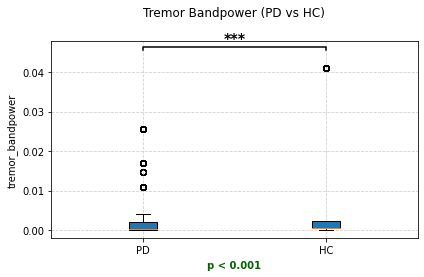

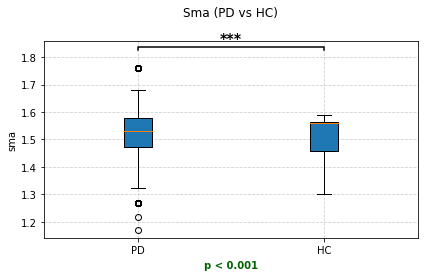

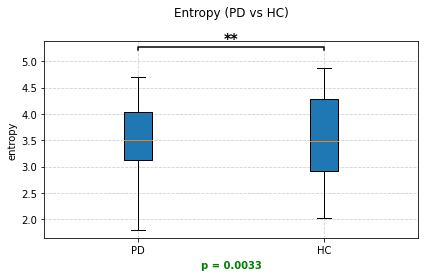

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

# Features to plot (based on your merged dataframe)
features_to_plot = ['tremor_amp', 'tremor_bandpower', 'sma', 'entropy']

test_results = []  # to store statistics

for feat in features_to_plot:
    try:
        # Extract PD and HC values
        pd_values = merged[merged["cohort_group"] == "PD"][feat].dropna()
        hc_values = merged[merged["cohort_group"] == "HC"][feat].dropna()

        # Mann–Whitney U test
        stat, p = mannwhitneyu(pd_values, hc_values, alternative='two-sided')
        test_results.append({"feature": feat, "U_statistic": stat, "p_value": p})

        # Determine significance level
        if p < 0.001:
            significance = '***'
            color = "darkgreen"
            weight = "bold"
        elif p < 0.01:
            significance = '**'
            color = "green"
            weight = "bold"
        elif p < 0.05:
            significance = '*'
            color = "green"
            weight = "bold"
        else:
            significance = ''
            color = "darkred"
            weight = "normal"

        # Format p-value
        p_str = f"p = {p:.4f}" if p >= 0.001 else "p < 0.001"

        # Plot boxplot
        fig, ax = plt.subplots(figsize=(6, 4))
        bp = ax.boxplot([pd_values, hc_values], labels=["PD", "HC"], patch_artist=True)
        ax.set_title(f"{feat.replace('_', ' ').title()} (PD vs HC)", pad=25)
        ax.set_ylabel(feat)
        ax.grid(True, linestyle="--", alpha=0.6)

        # Add p-value text below
        ax.annotate(p_str,
                    xy=(0.5, -0.15),
                    xycoords='axes fraction',
                    ha='center', fontsize=10,
                    color=color, fontweight=weight)

        # Draw asterisk annotation above box
        if significance:
            y_min, y_max = ax.get_ylim()
            max_val = max(pd_values.max(), hc_values.max())
            height = (y_max - y_min) * 0.1
            y_line = max_val + height
            y_star = y_line + (height * 0.2)
            y_text = y_star + (height * 0.1)

            ax.plot([1, 1, 2, 2], [y_line, y_star, y_star, y_line], lw=1.5, color='black')
            ax.text(1.5, y_text, significance, ha='center', va='bottom',
                    color='black', fontsize=14, fontweight='bold')

            ax.set_ylim(y_min, y_text + (height * 0.2))

        # Save and show
        plt.tight_layout()
        plt.savefig(f"boxplot_{feat}.png", dpi=150)
        plt.show()

    except Exception as e:
        print(f" Skipping {feat} due to error: {e}")


In [13]:
# Convert results to DataFrame
results_df = pd.DataFrame(test_results)

# Add significance labels
def get_significance(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

results_df['significance'] = results_df['p_value'].apply(get_significance)
results_df = results_df.sort_values(by='p_value')

print(" Mann–Whitney U Test Results")
display(results_df)


 Mann–Whitney U Test Results


,feature,U_statistic,p_value,significance
1,tremor_bandpower,614409.0,4.608840e-29,***
0,tremor_amp,663377.0,4.660575e-20,***
2,sma,995270.0,6.707725e-06,***
3,entropy,814703.0,3.316372e-03,**


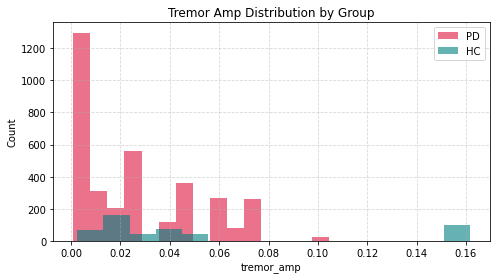

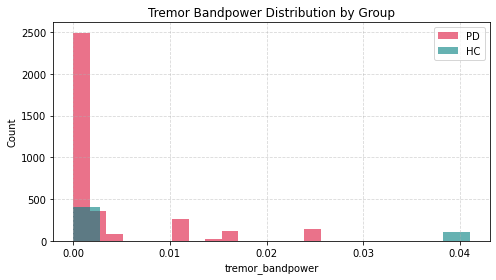

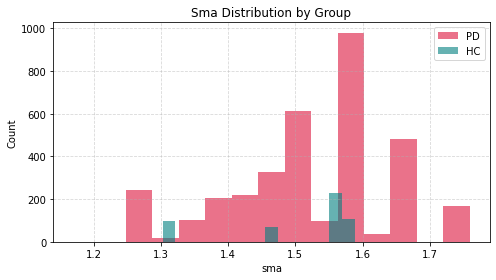

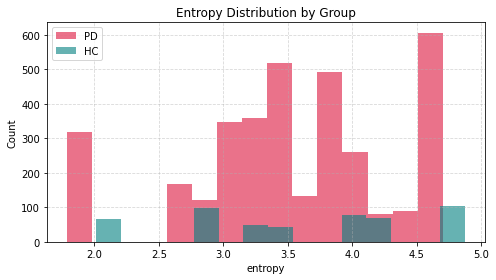

In [14]:
for feat in features_to_plot:
    try:
        pd_vals = merged[merged["cohort_group"] == "PD"][feat].dropna()
        hc_vals = merged[merged["cohort_group"] == "HC"][feat].dropna()

        plt.figure(figsize=(7, 4))
        plt.hist(pd_vals, bins=15, alpha=0.6, label='PD', color='crimson')
        plt.hist(hc_vals, bins=15, alpha=0.6, label='HC', color='teal')
        plt.title(f"{feat.replace('_', ' ').title()} Distribution by Group")
        plt.xlabel(feat)
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.savefig(f"hist_{feat}.png", dpi=150)
        plt.show()
    except Exception as e:
        print(f" Skipping {feat}: {e}")


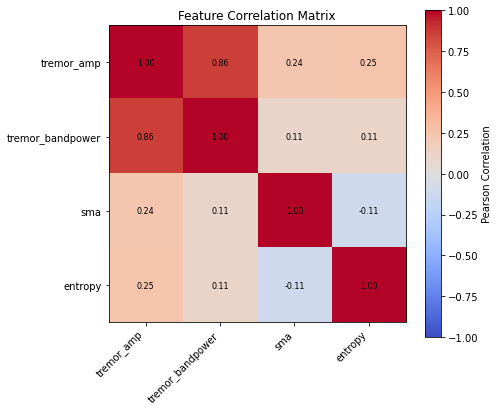

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# === Step 1: Compute correlation matrix ===
features = merged[features_to_plot]
n = len(features.columns)
corr_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        col1 = features.iloc[:, i]
        col2 = features.iloc[:, j]
        corr, _ = pearsonr(col1, col2)
        corr_matrix[i, j] = corr

# === Step 2: Plot heatmap with correlation values only ===
fig, ax = plt.subplots(figsize=(7, 6))
cax = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Labels
labels = features.columns
ax.set_xticks(np.arange(n))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(labels)

# Annotate with correlation values (no p-values)
for i in range(n):
    for j in range(n):
        corr_val = corr_matrix[i, j]
        ax.text(j, i, f"{corr_val:.2f}", ha='center', va='center',
                fontsize=8, color='black')

# Colorbar and title
fig.colorbar(cax, label='Pearson Correlation')
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig("feature_correlation_matrix.png", dpi=150)
plt.show()


In [19]:
# Load trimmed participant summary
trimmed_summary = pd.read_csv("/rds/general/user/nk2622/home/participant_activity3_17_summary.csv")

# Get unique participant IDs
valid_ids = trimmed_summary["Participant_ID"].astype(str).unique()

# Filter merged_df
filtered_df = merged_df[merged_df['participant_id'].astype(str).isin(valid_ids)].copy()

# Check balance
print(filtered_df['cohort_group'].value_counts())


PD    3495
HC     507
Name: cohort_group, dtype: int64


In [20]:
grouped_df = filtered_df.groupby('participant_id').agg({
    'tremor_amp': 'mean',
    'tremor_bandpower': 'mean',
    'sma': 'mean',
    'entropy': 'mean',
    'cohort_group': 'first'  # assumes group doesn't vary within participant
}).reset_index()


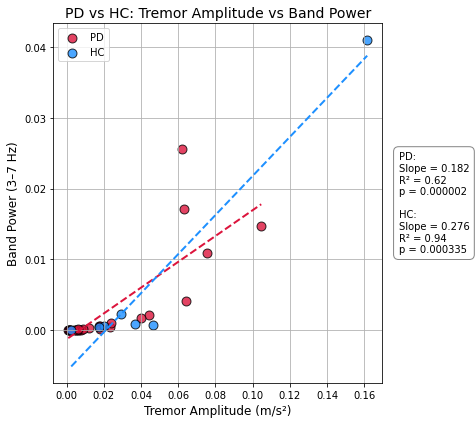

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# === Band Power vs Tremor Amplitude (grouped_df) ===
plt.figure(figsize=(8, 6))

groups = ['PD', 'HC']
colors = {'PD': 'crimson', 'HC': 'dodgerblue'}

# Dictionary to hold regression stats
stats_text = {}

for group in groups:
    subset = grouped_df[grouped_df['cohort_group'] == group]
    plt.scatter(
        subset['tremor_amp'],
        subset['tremor_bandpower'],
        label=group,
        color=colors[group],
        alpha=0.8,
        edgecolors='k',
        s=80
    )

    # Add linear trendline and regression stats
    if len(subset) >= 2:
        x = subset['tremor_amp']
        y = subset['tremor_bandpower']
        slope, intercept, r, p, stderr = linregress(x, y)
        x_vals = np.linspace(x.min(), x.max(), 100)
        y_vals = slope * x_vals + intercept
        plt.plot(x_vals, y_vals, linestyle='--', color=colors[group], linewidth=2)

        # Store stats for later annotation
        stats_text[group] = (
            f"{group}:\n"
            f"Slope = {slope:.3f}\n"
            f"R² = {r**2:.2f}\n"
            f"p = {p:.6f}"  # 6 decimal places
        )

# Plot settings
plt.xlabel('Tremor Amplitude (m/s²)', fontsize=12)
plt.ylabel('Band Power (3–7 Hz)', fontsize=12)
plt.title('PD vs HC: Tremor Amplitude vs Band Power', fontsize=14)
plt.legend()
plt.grid(True)

# === Add stats box to side ===
all_text = "\n\n".join(stats_text[group] for group in groups)
props = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray', alpha=0.95)
plt.gca().text(
    1.05, 0.5, all_text, transform=plt.gca().transAxes,
    fontsize=10, verticalalignment='center', bbox=props
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # make space for side text box
plt.savefig("scatter_tremor_amp_vs_bandpower_with_stats_box.png", dpi=150)
plt.show()


In [35]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


In [36]:
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


RandomForest Accuracy: 0.67, F1: 0.80, AUC: 0.28
              precision    recall  f1-score   support

          HC       0.00      0.00      0.00         7
          PD       0.76      0.85      0.80        26

    accuracy                           0.67        33
   macro avg       0.38      0.42      0.40        33
weighted avg       0.60      0.67      0.63        33

LogisticRegression Accuracy: 0.79, F1: 0.88, AUC: 0.24
              precision    recall  f1-score   support

          HC       0.00      0.00      0.00         7
          PD       0.79      1.00      0.88        26

    accuracy                           0.79        33
   macro avg       0.39      0.50      0.44        33
weighted avg       0.62      0.79      0.69        33

DecisionTree Accuracy: 0.55, F1: 0.69, AUC: 0.40
              precision    recall  f1-score   support

          HC       0.10      0.14      0.12         7
          PD       0.74      0.65      0.69        26

    accuracy                 

/rds/general/user/nk2622/home/pdkit-env/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/rds/general/user/nk2622/home/pdkit-env/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/rds/general/user/nk2622/home/pdkit-env/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

XGBoost Accuracy: 0.61, F1: 0.75, AUC: 0.19
              precision    recall  f1-score   support

          HC       0.00      0.00      0.00         7
          PD       0.74      0.77      0.75        26

    accuracy                           0.61        33
   macro avg       0.37      0.38      0.38        33
weighted avg       0.58      0.61      0.59        33



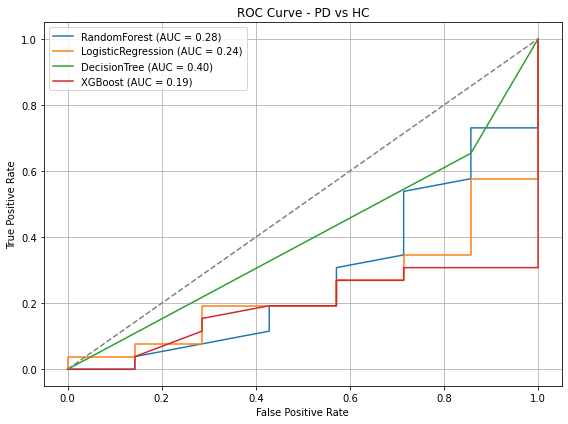

In [37]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, roc_curve

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# For ROC/AUC
plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_true_all, y_pred_all, y_proba_all = [], [], []

    for train_idx, test_idx in cv.split(X, y):
        model.fit(X.iloc[train_idx], y[train_idx])
        y_pred = model.predict(X.iloc[test_idx])
        y_proba = model.predict_proba(X.iloc[test_idx])[:, 1]  # Prob for class 1 (PD)

        y_true_all.extend(y[test_idx])
        y_pred_all.extend(y_pred)
        y_proba_all.extend(y_proba)

    acc = accuracy_score(y_true_all, y_pred_all)
    f1 = f1_score(y_true_all, y_pred_all)
    auc_score = roc_auc_score(y_true_all, y_proba_all)

    print(f"{name} Accuracy: {acc:.2f}, F1: {f1:.2f}, AUC: {auc_score:.2f}")
    print(classification_report(y_true_all, y_pred_all, target_names=['HC', 'PD']))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true_all, y_proba_all)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

# Plot config
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - PD vs HC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_all_models.png", dpi=150)
plt.show()
